# Giới thiệu functools 

### BS. Lê Ngọc Khả Nhi

functools là một module cấu trúc trong Python, nó cung cấp một số công cụ, nhằm mục tiêu hỗ trợ người dùng trong công việc lập trình hàm. Trong bài thực hành này, Nhi sẽ giới thiệu với các bạn về tính năng của các công cụ này.

In [1]:
from functools import *

# Hàm reduce

Hàm reduce cho phép áp dụng một quy trình mang tính chất tuần tự, nối tiếp trên một đối tượng iterable (chuỗi dữ liệu).

Thí dụ: ta muốn tính tổng của một dãy số [1,2,3,4,5], tức là thực hiện:

(((1+2)+3)+4)+5)

Nếu dùng hàm reduce và 1 hàm lambda, ta có thể viết code như sau:

In [20]:
seq = [1,2,3,4,5]

print(seq)

reduce(lambda a,b: a+b, seq)

[1, 2, 3, 4, 5]


15

Ta có thể làm tương tự để tính tích của các số trong dãy số: 

In [21]:
reduce(lambda a,b: a*b, seq)

120

Hàm reduce có thể dùng để tìm giá trị lớn nhất, nhỏ nhất trong dãy số:

In [22]:
reduce(lambda a,b: max(a,b), seq)

5

In [23]:
reduce(lambda a,b: min(a,b), seq)

1

# total_ordering

total_ordering là 1 decorator mà functools cung cấp, nó cho phép tự động thêm những dunder (magic) method có tính năng so sánh trong một class.

Để minh họa, chúng ta làm thí dụ sau:

Giả sử ta có 1 class Model() có nội dung fit một mô hình GLM từ design matrix x và biến kết quả y, family tùy chọn. Sau khi fit mô hình, giá trị AIC được lưu lại như 1 thuộc tính của class. Sau đó, ta dùng dunder method \__lt\__ để cho phép so sánh AIC giữa 2 phiên bản mô hình (2 instances tạo ra từ 1 class Model)

In [77]:
class Model():
    def __init__(self, x,y,family):
        self.mod = sm.GLM(y,x,family=family).fit()
        self.aic = self.mod.aic
    
    def __lt__(self, other):
        return self.aic < other.aic

In [24]:
import statsmodels.api as sm

In [68]:
data = sm.datasets.scotland.load(as_pandas=False)

data.exog = sm.add_constant(data.exog)

In [78]:
mod_1 = Model(x=data.exog, y = data.endog, family = sm.families.Gaussian())

In [42]:
mod_1.aic

179.68846616424918

In [79]:
mod_2 = Model(x=data.exog, y = data.endog, family = sm.families.Gamma())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:278: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [80]:
mod_2.aic

182.03440432214347

Trong thí dụ này, ta so sánh AIC giữa 2 mô hình Gaussian (mod_1) và Gamma (mod_2): dunder method \__lt\__ cho phép dùng toán tử so sánh < giữa 2 object models

In [81]:
mod_1 < mod_2

True

Tuy nhiên, khi ta dùng toán tử >= hay <=, chương trình sẽ báo lỗi, vì những method này chưa hiện diện trong class

In [84]:
mod_1 <= mod_2

TypeError: '<=' not supported between instances of 'Model' and 'Model'

Bây giờ, bạn thử đặt decorator @total_ordering trước đoạn code tạo class Model

In [86]:
@total_ordering
class Model():
    def __init__(self, x,y,family):
        self.mod = sm.GLM(y,x,family=family).fit()
        self.aic = self.mod.aic
    
    def __lt__(self, other):
        return self.aic < other.aic

In [87]:
mod_1 = Model(x=data.exog, y = data.endog, family = sm.families.Gaussian())
mod_2 = Model(x=data.exog, y = data.endog, family = sm.families.Gamma())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:278: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


Điều kì diệu xảy ra: Bạn chỉ cần dùng 1 dunder method \__lt\__ hay  '\__gt\_' , nhưng @total_ordering tự động thêm vào tính năng so sánh với tất cả toán tử còn lại, bạn có thể thoải mái dùng >= hay <=

In [98]:
for expr in ['mod_1 < mod_2', 
             'mod_1 <= mod_2', 
             'mod_1 == mod_2',
             'mod_1 >= mod_2', 
             'mod_1 > mod_2']:
    
    print(f'\n{expr:<6}:')
    result = eval(expr)
    out = 'Đúng' if result else 'Sai'
    print(f'Kết quả so sánh {expr}: {out}')


mod_1 < mod_2:
Kết quả so sánh mod_1 < mod_2: Đúng

mod_1 <= mod_2:
Kết quả so sánh mod_1 <= mod_2: Đúng

mod_1 == mod_2:
Kết quả so sánh mod_1 == mod_2: Sai

mod_1 >= mod_2:
Kết quả so sánh mod_1 >= mod_2: Sai

mod_1 > mod_2:
Kết quả so sánh mod_1 > mod_2: Sai


# lru_cache

lru_cache là một decorator sử dụng cho các hàm đệ quy (recursive function), nó cho phép ghi nhớ giá trị của những lần sử dụng gần nhất của hàm đó.

Để minh họa cho ý tưởng này, Nhi viết 1 hàm đệ quy để tính FiO2 (phân suất O2 hít vào phổi) trên bệnh nhân hít oxy 100% bằng catheter qua mũi, tùy theo lưu lượng cung cấp từ bình Oxy:

Công thức tính như sau:

Khi không dùng Oxy liệu pháp, (lưu lượng  = 0), FiO2 trong khí quyển = 21%

Cho 3 lít đầu tiên: FiO2 = 21% + 4%*Flow

Sau đó, kể từ 4L trở lên: FiO2 = 21% + 3*4% + 3%*flow

Công thức này có thể thực hiện qua 1 hàm đệ quy:

In [209]:
def fio2(flow):
    if flow <= 3:
        print(f'tính FiO2 cho lưu lượng = {flow} L')
        return flow*4 + 21
    print(f'tính FiO2 cho lưu lượng = {flow} L')
    return(fio2(flow - 1) + 3)

Lưu ý: mỗi lần hàm này được gọi, nó đều in 1 dòng thông báo: thí dụ cho flow = 6, hàm được gọi 4 lần:

In [210]:
fio2(6)

tính FiO2 cho lưu lượng = 6 L
tính FiO2 cho lưu lượng = 5 L
tính FiO2 cho lưu lượng = 4 L
tính FiO2 cho lưu lượng = 3 L


42

Nếu bạn đặt decorator @lru_cache khi tạo hàm đệ quy: tính năng ghi nhớ kết quả được tích hợp;

In [219]:
@lru_cache(maxsize = None)
def fio2(flow):
    if flow <= 3:
        print(f'tính FiO2 cho lưu lượng = {flow} L')
        return flow*4 + 21
    print(f'tính FiO2 cho lưu lượng = {flow} L')
    return(fio2(flow - 1) + 3)

Bạn thi hành hàm này cho giá trị flow = 10

In [220]:
fio2(10)

tính FiO2 cho lưu lượng = 10 L
tính FiO2 cho lưu lượng = 9 L
tính FiO2 cho lưu lượng = 8 L
tính FiO2 cho lưu lượng = 7 L
tính FiO2 cho lưu lượng = 6 L
tính FiO2 cho lưu lượng = 5 L
tính FiO2 cho lưu lượng = 4 L
tính FiO2 cho lưu lượng = 3 L


54

Sau đó, bạn thử chạy hàm này cho 7 giá trị khác nhau từ 3-10:

In [222]:
[fio2(i) for i in range(3,10)]

[33, 36, 39, 42, 45, 48, 51]

Ta thấy không có dòng thông báo nào được in ra cả, vì thực chất hàm không hề chạy cho mỗi giá trị flow từ 3-10, nhưng chỉ sử dụng lại các kết quả ghi lại từ trước, vì trước đó nó đã được gọi 7 lần cho các giá trị này; kết quả những lần đó đã được ghi lại, và tái sử dụng mà không cần gọi hàm lại từ đầu.

# Hàm partial

Hàm partial cho phép tạo ra các phiên bản khác nhau từ 1 hàm nguyên thủy bằng cách thay đổi 1 bộ phận các arguments của hàm này:

Thí dụ, từ hàm distplot của seaborn, ta có thể tạo ra 2 hàm hist_plot và kde_plot thông qua hàm partial của functools:

In [130]:
import seaborn as sns

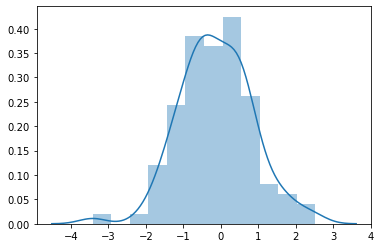

In [135]:
sns.distplot(np.random.normal(size=100), kde = True)

In [156]:
hist_plot = partial(sns.distplot, kde = False)
kde_plot = partial(sns.distplot, hist = False, rug = True)

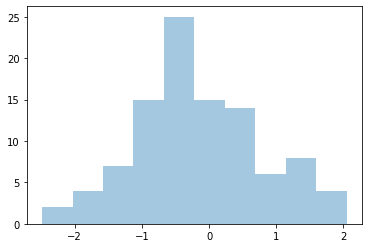

In [157]:
hist_plot(np.random.normal(size=100))

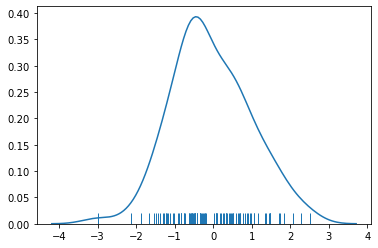

In [158]:
kde_plot(np.random.normal(size=100))

# wraps

wraps là một decorator trong functools, nó cho phép lưu lại tên và doc_string cho hàm mục tiêu khi đóng gói hàm mục tiêu này qua 1 decorator khác,

Thí dụ: nếu không dùng wraps, khi ta đóng gói hàm single_glm bằng decorator my_logger, tên và docstring của hàm single_glm không được sử dụng

In [178]:
def my_logger(func):
    def wrapper(*args, **kwargs):
        print(f'Đóng gói {func.__name__}')
        return func(*args, **kwargs)
    return wrapper

In [179]:
@my_logger
def simple_glm(x,y, family):
    '''Hàm fit mô hình GLM'''
    return sm.GLM(y,x,family=family).fit()

In [180]:
mod_1 = simple_glm(x=data.exog, y = data.endog, family = sm.families.Gaussian())

Đóng gói simple_glm


Tên của hàm single_glm được cho là 'wrapper'

In [181]:
simple_glm.__name__

'wrapper'

docstring của hàm single_glm bị xóa sạch

In [182]:
simple_glm.__doc__

Khi có dùng wraps ngay trước hàm đóng gói wrapper của decorator my_logger, ta sẽ thấy hàm mục tiêu được lưu giữ trọn vẹn thông tin gồm tên của nó và docstring:

In [169]:
def my_logger(func):
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        print(f'Đóng gói {func.__name__}')
        return func(*args, **kwargs)
    return wrapper

In [174]:
@my_logger
def simple_glm(x,y, family):
    '''Hàm fit mô hình GLM'''
    return sm.GLM(y,x,family=family).fit()

In [175]:
mod_1 = simple_glm(x=data.exog, y = data.endog, family = sm.families.Gaussian())

Đóng gói simple_glm


Tên của hàm đúng là simple_glm

In [176]:
simple_glm.__name__

'simple_glm'

Docstring được bảo tồn

In [177]:
simple_glm.__doc__

'Hàm fit mô hình GLM'

# singledispatch

singledispatch là 1 decorator cho phép tạo ra những phiên bản khác nhau từ 1 hàm cơ bản, mỗi phiên bản áp dụng cho 1 data type chuyên biệt; nhưng dùng chung 1 tên hàm

Thí dụ, từ 1 hàm rỗng có tên là cal_mean, ta có thể tạo ra 3 phiên bản khác nhau để tính trung bình (mean) cho 1 list, 1 numpy array hay 1 pandas Series. Kết quả sau cùng là ta có 1 hàm cal_mean có khả năng tương thích với 3 data types, và với type nào nó cũng làm cùng 1 chức năng là tính trung bình.

Việc sử dụng singledispatch thay thế cho chuỗi điều kiện if elif, else... phức tạp nếu bạn muốn kiểm tra datatype, code của bạn sẽ đon giản, dễ hiểu và dễ debug hơn.

In [194]:
@singledispatch
def cal_mean(obj):
    pass

@cal_mean.register(list)
def _(obj):
    return reduce(lambda a,b: a+b, obj)/len(obj)

@cal_mean.register(pd.core.series.Series)
def _(obj):
    return obj.mean()

@cal_mean.register(np.ndarray)
def _(obj):
    return obj.mean()

In [184]:
import pandas as pd
import numpy as np

lst = [1,3,0,2,8,5,9,7]
arr = np.asarray(lst)
pds = pd.Series(lst)

In [195]:
cal_mean(lst)

4.375

In [196]:
cal_mean(arr)

4.375

In [197]:
cal_mean(pds)

4.375

Chúc các bạn thực hành lập trình hàm thật vui và thành công với functools. Hẹn gặp lại lần sau nhé:)